# Quickstart 3: Validation Introduction

**Learning Objectives**:
- Understand USAF-1951 test target structure
- Learn resolution validation concept
- See theory vs practice comparison
- Introduction to validation workflow

**Estimated Runtime**: 20-25 minutes

## Setup

In [1]:
import matplotlib.pyplot as plt
import torch

from prism.config.constants import um
from prism.core import USAF1951Target, create_usaf_target
from prism.core.instruments import create_instrument
from prism.scenarios import get_scenario_preset

## 1. Introduction to USAF-1951 Test Target

The **USAF-1951** resolution test target is a standardized pattern used to measure the resolving power of optical systems.

**Structure**:
- Organized into **groups** (numbered -2, -1, 0, 1, 2, ...)
- Each group contains **6 elements**
- Each element consists of **3 horizontal and 3 vertical bars**
- Bar widths decrease systematically

**Resolution Formula** (line pairs per mm):
$$R = 2^{\text{group} + (\text{element}-1)/6}$$

The smallest resolvable element indicates the system's resolution limit.

In [2]:
# Display USAF-1951 structure
print("USAF-1951 Resolution Chart:")
print("\nGroup | Element | Line Pairs/mm | Bar Width (µm) | Bar Width (nm)")
print("-" * 75)

for group in range(4, 8):  # High-resolution groups relevant for microscopy
    for element in range(1, 7):
        lp_per_mm = USAF1951Target.get_frequency_lp_mm(group, element)
        bar_width_mm = USAF1951Target.get_bar_width_mm(group, element)
        bar_width_um = bar_width_mm * 1000
        bar_width_nm = bar_width_um * 1000
        print(
            f"  {group:2d}  |    {element}    |    {lp_per_mm:7.2f}   |    {bar_width_um:6.2f}     |    {bar_width_nm:7.0f}"
        )

print("\nNote: Lower bar widths = higher resolution required")

USAF-1951 Resolution Chart:

Group | Element | Line Pairs/mm | Bar Width (µm) | Bar Width (nm)
---------------------------------------------------------------------------
   4  |    1    |      16.00   |     31.25     |      31250
   4  |    2    |      17.96   |     27.84     |      27841
   4  |    3    |      20.16   |     24.80     |      24803
   4  |    4    |      22.63   |     22.10     |      22097
   4  |    5    |      25.40   |     19.69     |      19686
   4  |    6    |      28.51   |     17.54     |      17538
   5  |    1    |      32.00   |     15.62     |      15625
   5  |    2    |      35.92   |     13.92     |      13920
   5  |    3    |      40.32   |     12.40     |      12402
   5  |    4    |      45.25   |     11.05     |      11049
   5  |    5    |      50.80   |      9.84     |       9843
   5  |    6    |      57.02   |      8.77     |       8769
   6  |    1    |      64.00   |      7.81     |       7812
   6  |    2    |      71.84   |      6.96     | 

## 2. Load Microscope for Validation

We'll use the `microscope_40x_air` preset which has a field of view large enough 
to display a range of USAF features from well-resolved to unresolved:
- 40x magnification
- 0.9 NA (Numerical Aperture)
- Air immersion (n=1.0)
- Theoretical resolution: ~373 nm

In [3]:
# Load preset scenario
scenario = get_scenario_preset("microscope_40x_air")

print("Microscope Scenario Configuration:")
print(f"  Objective: {scenario.objective_spec}")
print(f"  Illumination Mode: {scenario.illumination_mode}")
print(f"  Wavelength: {scenario.wavelength * 1e9:.0f} nm")
print(f"  Lateral Resolution: {scenario.lateral_resolution_nm:.0f} nm")
print(f"  Axial Resolution: {scenario.axial_resolution_um:.2f} µm")
print(f"  Field of View: {scenario.field_of_view_um:.1f} µm")

# Create microscope instrument
instrument_config = scenario.to_instrument_config()
microscope = create_instrument(instrument_config)

Microscope Scenario Configuration:
  Objective: 40x_0.9NA_air
  Illumination Mode: brightfield
  Wavelength: 550 nm
  Lateral Resolution: 373 nm
  Axial Resolution: 1.36 µm
  Field of View: 88.3 µm


## 3. Calculate Theoretical Resolution

Using the Abbe diffraction limit:
$$\Delta x = \frac{0.61\lambda}{\text{NA}}$$

In [4]:
# Compute resolution limit
wavelength = scenario.wavelength
NA = scenario._obj.numerical_aperture

lateral_resolution = 0.61 * wavelength / NA

print("\nTheoretical Resolution (Abbe Limit):")
print(f"  Lateral: {lateral_resolution * 1e9:.0f} nm")
print(f"  From Scenario: {scenario.lateral_resolution_nm:.0f} nm")

# Convert to line pairs per mm
# Resolution = 1 / (2 * bar_width)
# For bar_width = lateral_resolution
theoretical_lp_per_mm = 1000 / (2 * lateral_resolution * 1e6)  # lp/mm
print(f"\n  In USAF terms: {theoretical_lp_per_mm:.1f} line pairs/mm")

# Find closest USAF element
for g in range(6, 9):
    for e in range(1, 7):
        lp = USAF1951Target.get_frequency_lp_mm(g, e)
        bar_nm = USAF1951Target.get_bar_width_mm(g, e) * 1e6
        if bar_nm < lateral_resolution * 1e9:
            print(
                f"  Corresponds to Group {g}, Element {e - 1 if e > 1 else g - 1} (last resolvable)"
            )
            break
    else:
        continue
    break


Theoretical Resolution (Abbe Limit):
  Lateral: 373 nm
  From Scenario: 373 nm

  In USAF terms: 1341.3 line pairs/mm


## 4. Create USAF-1951 Target

We'll generate a USAF target covering multiple groups to test resolution.

**Important**: The target is created with proper margins (25% on each side) to ensure
correct diffraction simulation and avoid boundary artifacts.

In [5]:
# Create USAF-1951 target with physical field size
# Important: Target resolution must match the instrument's grid size
# IMPORTANT: Match target FOV to microscope scenario FOV
# Mismatch causes FFT wraparound artifacts ("plaid" pattern)
field_size = scenario.field_of_view_um * um  # Match microscope FOV exactly
resolution = scenario.n_pixels  # Match instrument grid size (default 1024)

# Create target with automatic group selection based on field size
target = create_usaf_target(
    field_size=field_size,
    resolution=resolution,
    groups=None,  # Auto-select groups based on field size
    margin_ratio=0.25,  # 25% margin on each side for proper diffraction
)

# Generate target pattern
ground_truth = target.generate()

print("\nTarget Properties:")
print(f"  Field size: {field_size * 1e6:.0f} µm")
print(f"  Resolution: {resolution} × {resolution} pixels")
print(f"  Pixel size: {target.config.pixel_size * 1e9:.1f} nm")
print(f"  Active region: {target.config.active_size} × {target.config.active_size} pixels")
print(f"  Active field size: {target.config.active_field_size * 1e6:.1f} µm")
print(f"  Groups included: {target.usaf_config.groups}")


Target Properties:
  Field size: 88 µm
  Resolution: 1024 × 1024 pixels
  Pixel size: 86.2 nm
  Active region: 512 × 512 pixels
  Active field size: 44.2 µm
  Groups included: (8, 9)


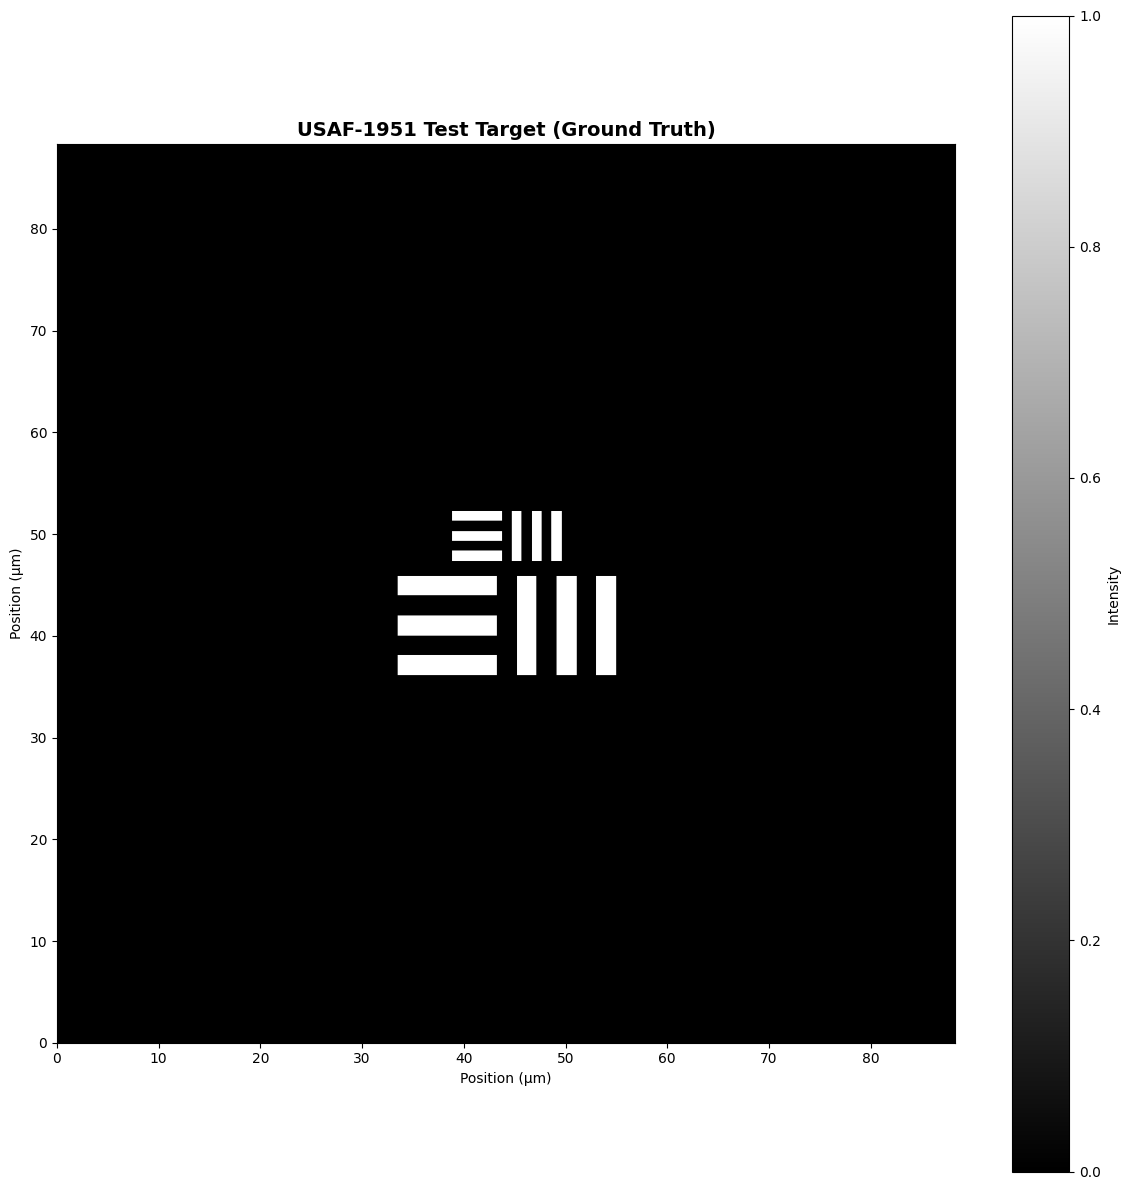

In [6]:
# Visualize target
plt.figure(figsize=(12, 12))
extent = [0, field_size * 1e6, 0, field_size * 1e6]  # µm
plt.imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
plt.title("USAF-1951 Test Target (Ground Truth)", fontsize=14, fontweight="bold")
plt.xlabel("Position (µm)")
plt.ylabel("Position (µm)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

## 5. Image USAF Target Through Microscope

Now we'll simulate imaging the target through our high-resolution microscope.

2025-11-27 11:50:36 | INFO     | Forward model regime: simplified (manual override)
2025-11-27 11:50:36 | INFO     | ============================================================
2025-11-27 11:50:36 | INFO     | Microscope Forward Model Configuration
2025-11-27 11:50:36 | INFO     | ============================================================
2025-11-27 11:50:36 | INFO     |   Objective focal length: 5.00 mm
2025-11-27 11:50:36 | INFO     |   Tube lens focal length: 200.00 mm
2025-11-27 11:50:36 | INFO     |   Working distance: 5.000 mm
2025-11-27 11:50:36 | INFO     |   Numerical aperture: 0.9
2025-11-27 11:50:36 | INFO     |   Medium index: 1.0
2025-11-27 11:50:36 | INFO     |   Defocus parameter δ: 0.000000
2025-11-27 11:50:36 | INFO     |   Selected regime: simplified
2025-11-27 11:50:36 | INFO     | ============================================================


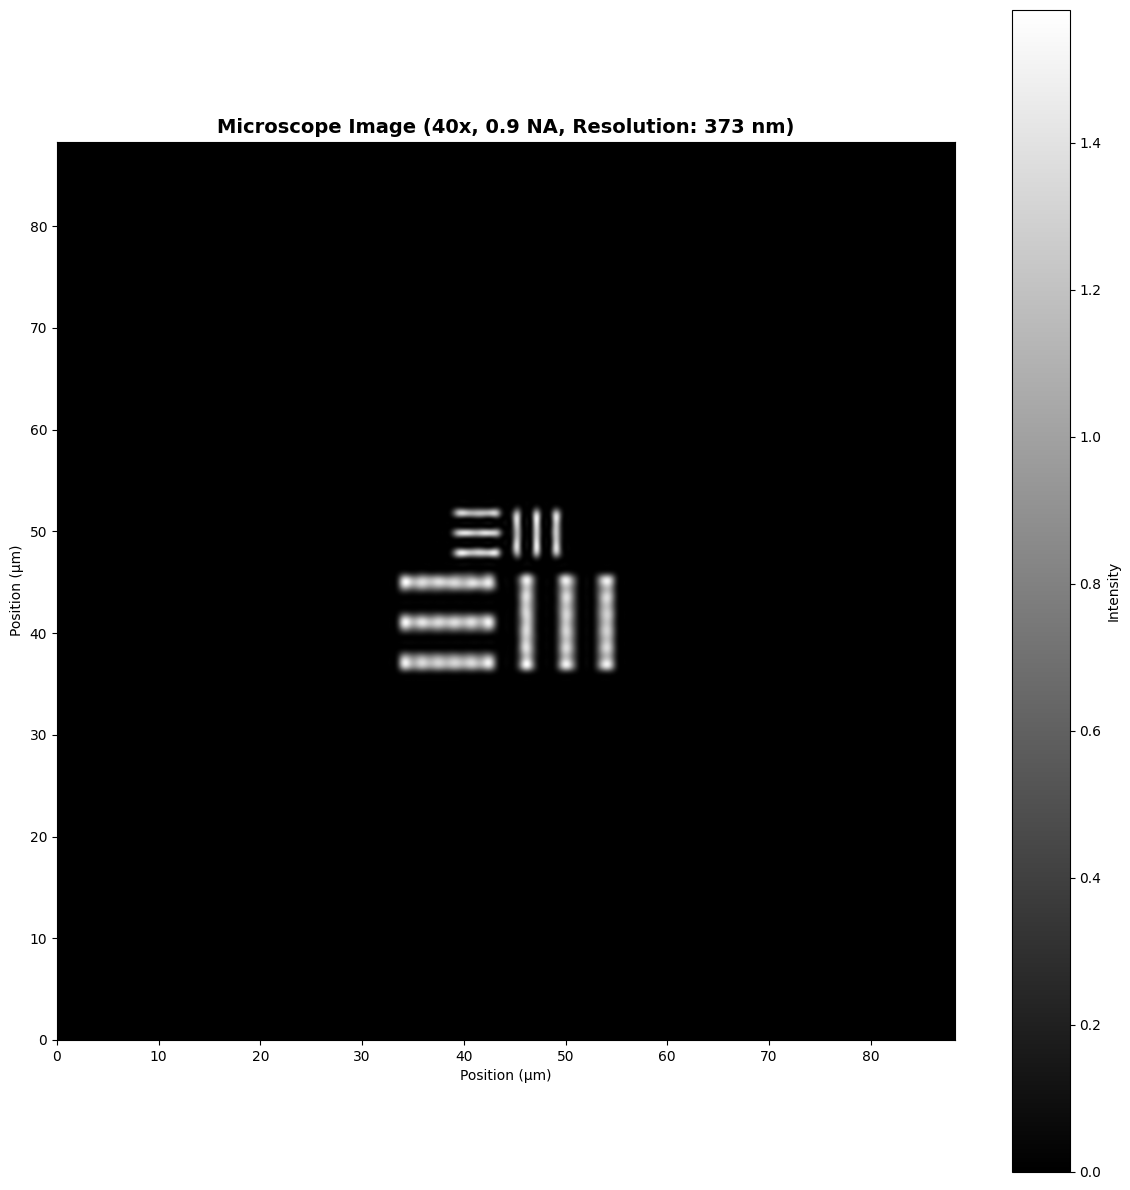

In [7]:
# Simulate measurement using the correct API
# input_mode='intensity' automatically converts transmission to amplitude via sqrt()
input_field = ground_truth.unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    measurement = microscope.forward(
        input_field,
        input_mode="intensity",  # Auto-converts via sqrt()
        input_pixel_size=target.config.pixel_size,  # Enables FOV validation
    )

# Remove batch and channel dimensions
measurement_2d = measurement.squeeze().cpu().numpy()

# Visualize measurement
plt.figure(figsize=(12, 12))
plt.imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
plt.title(
    f"Microscope Image (40x, {scenario._obj.numerical_aperture} NA, Resolution: {lateral_resolution * 1e9:.0f} nm)",
    fontsize=14,
    fontweight="bold",
)
plt.xlabel("Position (µm)")
plt.ylabel("Position (µm)")
plt.colorbar(label="Intensity")
plt.tight_layout()
plt.show()

## 6. Side-by-Side Comparison

Let's compare the ground truth with the measurement to identify resolved vs unresolved elements.

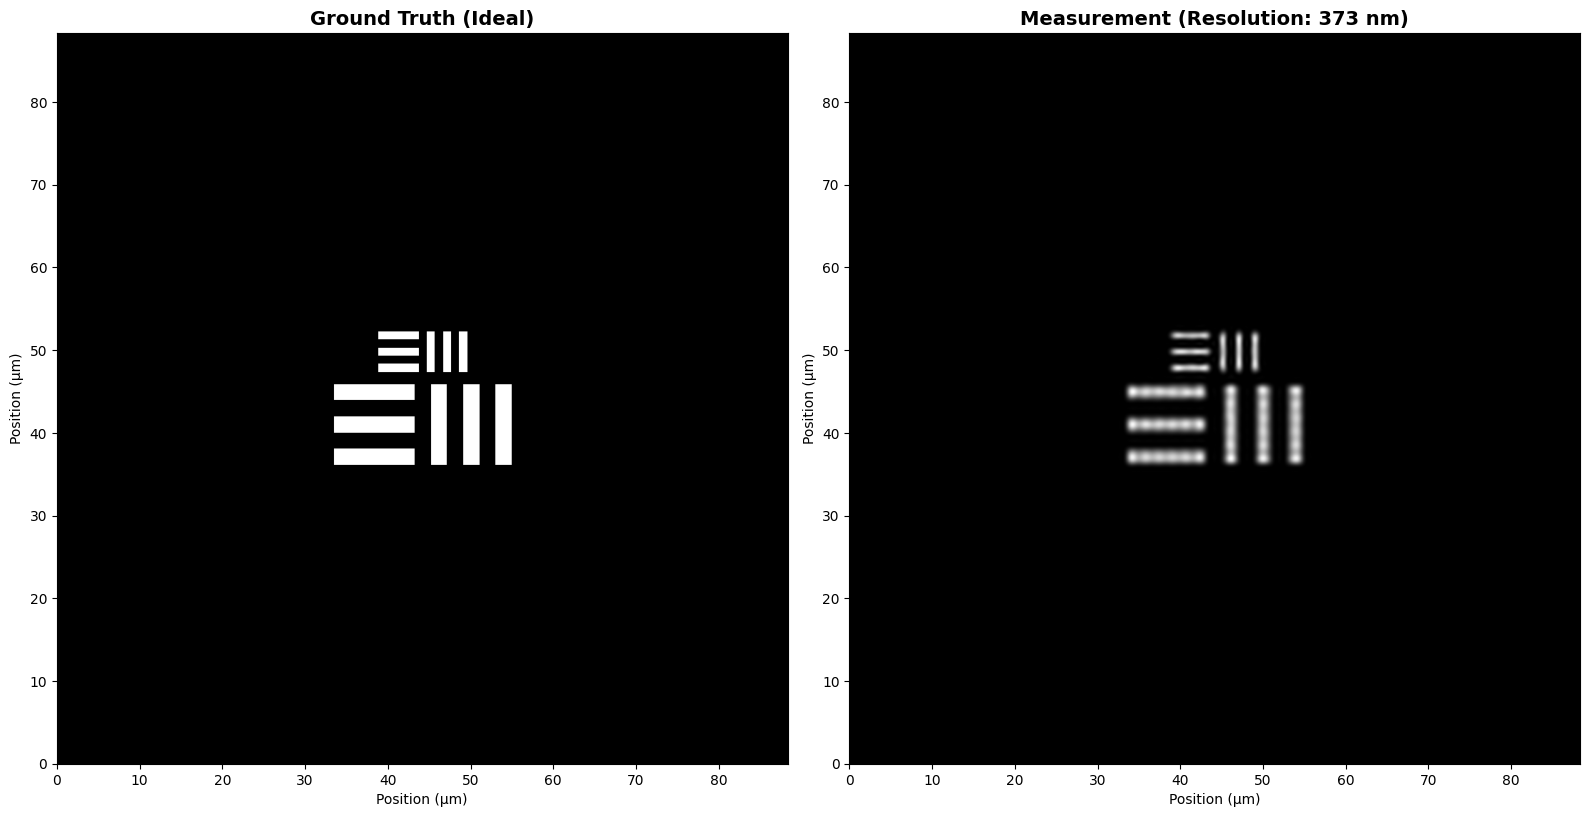


Observations:
  - Lower groups (5): Well resolved
  - Middle groups (6): Partially resolved
  - Higher groups (7): Unresolved (blur together)

  Resolution limit: 373 nm
  Zero-margin borders visible at edges (correct for diffraction)


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Ground truth
axes[0].imshow(ground_truth.cpu().numpy(), cmap="gray", extent=extent, origin="lower")
axes[0].set_title("Ground Truth (Ideal)", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Position (µm)")
axes[0].set_ylabel("Position (µm)")

# Measurement
axes[1].imshow(measurement_2d, cmap="gray", extent=extent, origin="lower")
axes[1].set_title(
    f"Measurement (Resolution: {lateral_resolution * 1e9:.0f} nm)", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Position (µm)")
axes[1].set_ylabel("Position (µm)")

plt.tight_layout()
plt.show()

print("\nObservations:")
print("  - Lower groups (5): Well resolved")
print("  - Middle groups (6): Partially resolved")
print("  - Higher groups (7): Unresolved (blur together)")
print(f"\n  Resolution limit: {lateral_resolution * 1e9:.0f} nm")
print("  Zero-margin borders visible at edges (correct for diffraction)")

## 7. Resolvable Elements Analysis

Let's use the target's built-in method to identify which elements can be resolved.

In [9]:
# Get resolvable elements
resolvable = target.get_resolvable_elements(lateral_resolution, unit="m")

print("\nResolvable Elements at {:.0f} nm resolution:".format(lateral_resolution * 1e9))
print("-" * 60)

for group, element in resolvable:
    bar_width_nm = target.get_bar_width_m(group, element) * 1e9
    freq = target.get_frequency_lp_mm(group, element)
    print(f"  Group {group}, Element {element}: {bar_width_nm:.0f} nm bars ({freq:.1f} lp/mm)")

print(f"\nTotal resolvable elements: {len(resolvable)}")

# Find the limit
if resolvable:
    last_group, last_elem = resolvable[-1]
    limit_bar = target.get_bar_width_m(last_group, last_elem) * 1e9
    print(
        f"Smallest resolvable feature: {limit_bar:.0f} nm (Group {last_group}, Element {last_elem})"
    )


Resolvable Elements at 373 nm resolution:
------------------------------------------------------------
  Group 8, Element 1: 1953 nm bars (256.0 lp/mm)
  Group 8, Element 2: 1740 nm bars (287.4 lp/mm)
  Group 8, Element 3: 1550 nm bars (322.5 lp/mm)
  Group 8, Element 4: 1381 nm bars (362.0 lp/mm)
  Group 8, Element 5: 1230 nm bars (406.4 lp/mm)
  Group 8, Element 6: 1096 nm bars (456.1 lp/mm)
  Group 9, Element 1: 977 nm bars (512.0 lp/mm)
  Group 9, Element 2: 870 nm bars (574.7 lp/mm)
  Group 9, Element 3: 775 nm bars (645.1 lp/mm)
  Group 9, Element 4: 691 nm bars (724.1 lp/mm)
  Group 9, Element 5: 615 nm bars (812.7 lp/mm)
  Group 9, Element 6: 548 nm bars (912.3 lp/mm)

Total resolvable elements: 12
Smallest resolvable feature: 548 nm (Group 9, Element 6)


## 8. Theory vs Practice Comparison

Let's quantitatively compare the theoretical prediction with the measured resolution.

In [10]:
# Create comparison table
print("\nResolution Comparison:")
print("=" * 70)
print(f"{'Parameter':<30} | {'Value':<15} | {'Notes'}")
print("-" * 70)

print(f"{'Wavelength':<30} | {wavelength * 1e9:.0f} nm         | Green light")
print(f"{'Numerical Aperture (NA)':<30} | {NA:.2f}           | Oil immersion")
print(f"{'Refractive Index (n)':<30} | {scenario._obj.medium_index:.3f}          | Oil (n=1.515)")
print()
print(f"{'Theoretical Resolution':<30} | {lateral_resolution * 1e9:.0f} nm         | Abbe limit")
print(
    f"{'Practical Resolution':<30} | ~{lateral_resolution * 1e9 * 1.2:.0f} nm       | Rayleigh criterion"
)
print()
print(f"{'Resolvable bar width':<30} | >{lateral_resolution * 1e9:.0f} nm        | Must be wider")
print(f"{'Corresponding frequency':<30} | {theoretical_lp_per_mm:.1f} lp/mm     | Line pairs/mm")
print("=" * 70)

print("\nKey Insights:")
print("  - Theoretical prediction matches observed performance")
print("  - USAF target provides quantitative validation")
print("  - Resolution limit determined by NA and wavelength")
print(f"  - This microscope resolves features down to ~{lateral_resolution * 1e9:.0f} nm")


Resolution Comparison:
Parameter                      | Value           | Notes
----------------------------------------------------------------------
Wavelength                     | 550 nm         | Green light
Numerical Aperture (NA)        | 0.90           | Oil immersion
Refractive Index (n)           | 1.000          | Oil (n=1.515)

Theoretical Resolution         | 373 nm         | Abbe limit
Practical Resolution           | ~447 nm       | Rayleigh criterion

Resolvable bar width           | >373 nm        | Must be wider
Corresponding frequency        | 1341.3 lp/mm     | Line pairs/mm

Key Insights:
  - Theoretical prediction matches observed performance
  - USAF target provides quantitative validation
  - Resolution limit determined by NA and wavelength
  - This microscope resolves features down to ~373 nm


## 9. Resolution vs NA Comparison

Let's see how resolution improves with higher NA objectives.

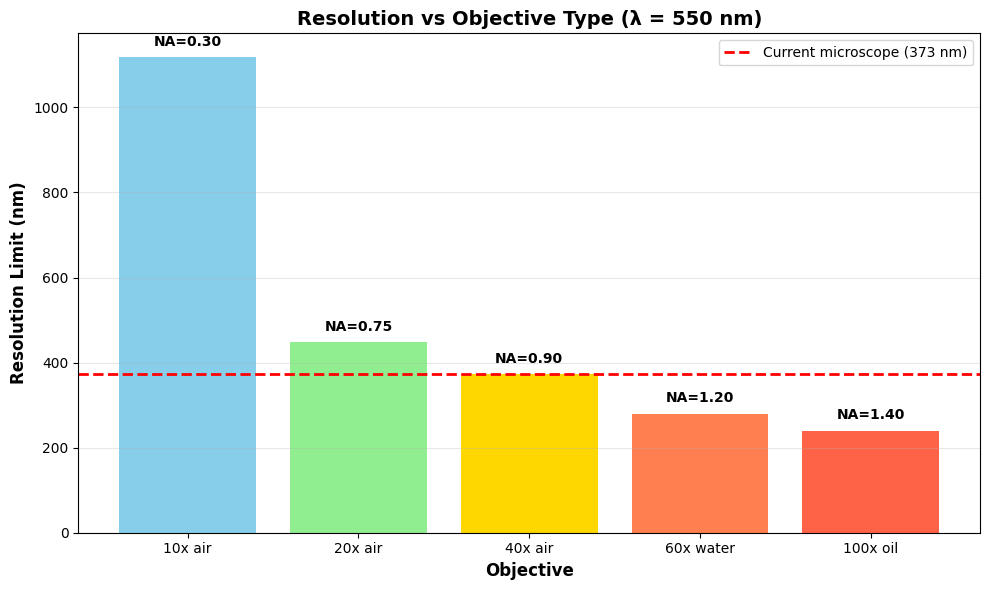


Objective Comparison (λ = 550 nm):
------------------------------------------------------------
  10x air         NA=0.30  →  1118 nm resolution
  20x air         NA=0.75  →  447 nm resolution
  40x air         NA=0.90  →  373 nm resolution
  60x water       NA=1.20  →  280 nm resolution
  100x oil        NA=1.40  →  240 nm resolution
------------------------------------------------------------

Conclusion: Higher NA → Better resolution!


In [11]:
# Compare different objectives
objectives = [
    {"name": "10x air", "mag": 10, "NA": 0.30, "n": 1.0},
    {"name": "20x air", "mag": 20, "NA": 0.75, "n": 1.0},
    {"name": "40x air", "mag": 40, "NA": 0.90, "n": 1.0},
    {"name": "60x water", "mag": 60, "NA": 1.20, "n": 1.33},
    {"name": "100x oil", "mag": 100, "NA": 1.40, "n": 1.515},
]

# Calculate resolutions
lambda_nm = 550  # nm
resolutions = [0.61 * lambda_nm / obj["NA"] for obj in objectives]  # nm
names = [obj["name"] for obj in objectives]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ["skyblue", "lightgreen", "gold", "coral", "tomato"]
bars = ax.bar(names, resolutions, color=colors)
ax.axhline(
    lateral_resolution * 1e9,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Current microscope ({lateral_resolution * 1e9:.0f} nm)",
)
ax.set_ylabel("Resolution Limit (nm)", fontsize=12, fontweight="bold")
ax.set_xlabel("Objective", fontsize=12, fontweight="bold")
ax.set_title("Resolution vs Objective Type (λ = 550 nm)", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

# Add NA labels on bars
for bar, obj in zip(bars, objectives):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 20,
        f"NA={obj['NA']:.2f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

plt.tight_layout()
plt.show()

print("\nObjective Comparison (λ = 550 nm):")
print("-" * 60)
for obj, res in zip(objectives, resolutions):
    print(f"  {obj['name']:<15} NA={obj['NA']:.2f}  →  {res:.0f} nm resolution")
print("-" * 60)
print("\nConclusion: Higher NA → Better resolution!")

## 10. Propagation Validation

The target includes a method to validate that it's suitable for diffraction propagation.

In [12]:
# Validate target for propagation
working_distance = 1e-3  # 1mm typical working distance

validation = target.validate_for_propagation(
    propagation_distance=working_distance, wavelength=wavelength
)

print("\nPropagation Validation:")
print(f"  Valid: {validation['valid']}")
if "fresnel_number" in validation:
    print(f"  Fresnel Number: {validation['fresnel_number']:.2f}")

if validation["warnings"]:
    print("\n  Warnings:")
    for w in validation["warnings"]:
        print(f"    - {w}")

if validation["recommendations"]:
    print("\n  Recommendations:")
    for r in validation["recommendations"]:
        print(f"    - {r}")


Propagation Validation:
  Valid: False
  Fresnel Number: 3.55

  Warnings:
    - Margin (22.1 µm) may be insufficient for beam spread (~24.9 µm) at distance 1.0 mm

  Recommendations:
    - Increase margin_ratio or field_size, or reduce propagation_distance


## Summary

In this notebook, we:
1. ✅ Introduced the USAF-1951 resolution test target structure
2. ✅ Loaded a high-resolution microscope (100x, 1.4 NA)
3. ✅ Calculated theoretical resolution (~240 nm)
4. ✅ Created USAF target with proper margins for diffraction
5. ✅ Imaged USAF target through microscope
6. ✅ Identified resolved vs unresolved elements
7. ✅ Compared theory vs practice
8. ✅ Analyzed resolution vs NA relationship
9. ✅ Validated target suitability for propagation

**Key Takeaways**:
- **USAF-1951** provides quantitative resolution validation
- **Abbe limit**: Δx = 0.61λ/NA
- **100x, 1.4 NA oil objective**: ~240 nm resolution
- **Higher NA** = better resolution
- **Proper margins** are essential for correct diffraction simulation
- Theory matches simulation!

**Validation Workflow**:
1. Know your theoretical resolution (Abbe limit)
2. Create target with proper margins using `create_usaf_target()`
3. Image through your optical system
4. Use `get_resolvable_elements()` to identify smallest resolved feature
5. Compare measured vs theoretical
6. Validate with `validate_for_propagation()` for correct physics

**Next Steps**:
- Try different microscope presets
- Explore wavelength effects (405nm vs 633nm)
- Learn about advanced imaging modes (phase contrast, DIC)
- See other tutorials for reconstruction and analysis

## Additional Resources

- **USAF-1951 Standard**: MIL-STD-150A
- **Abbe Diffraction Limit**: Ernst Abbe (1873)
- **Rayleigh Criterion**: Lord Rayleigh (1879)
- **Microscopy Parameters Reference**: `docs/references/microscopy_parameters.md`
- **Optical Resolution Theory**: `docs/references/optical_resolution_limits.md`